In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [73]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2024-09-26 17:29:37--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1,36M  8,40MB/s    in 0,2s    

2024-09-26 17:29:37 (8,40 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [74]:
df = pd.read_csv('housing.csv')

## EDA

In [75]:
df.shape

(20640, 10)

In [76]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [77]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [78]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


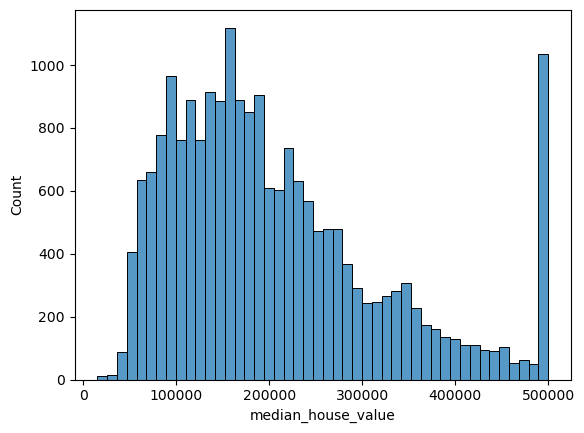

In [79]:
sns.histplot(df['median_house_value'])
plt.show()

In [80]:
df_filt = df[(df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND']))]
df_filt = df_filt.drop(columns='ocean_proximity')

In [81]:
df_filt['population'].median()

1195.0

In [82]:
def split_data (df_filt, seed_value):

    df_shuffled = df_filt.sample(frac=1.0, random_state=seed_value)

    n_values = len(df_shuffled)
    share_test = 0.2
    share_val = 0.2

    df_test = df_shuffled[:int(n_values*share_test)].reset_index(drop=True)
    df_val = df_shuffled[int(n_values*share_test): int(n_values*(share_test+share_val))].reset_index(drop=True)
    df_train = df_shuffled[int(n_values*(share_test+share_val)):].reset_index(drop=True)

    return (df_test, df_val, df_train)




In [83]:
df_test, df_val, df_train = split_data(df_filt, 42)

In [84]:
def prep_y (df):
    return np.log1p(df['median_house_value'])

def revert_prep_y (y):
    return np.expm1(y)

In [85]:
def prep_x (df_inp, impute_value_bedroom):
    df = df_inp.copy()
    df['total_bedrooms']=df['total_bedrooms'].fillna(impute_value_bedroom)
    #df = df - df.mean()
    #df / (df.max() - df.min())
    df['bias'] = 1
    df = df.drop(columns='median_house_value')



    return np.array(df)

In [86]:
def lin_regression (X, y, reg_par=0):
    XTX = (X.T).dot(X)
    XTX_reg = XTX + np.eye(XTX.shape[0])*reg_par
    w = np.linalg.inv(XTX_reg).dot(X.T).dot(y)
    return w


In [87]:
def RMSE (y_pred, y_ori):
    return  np.sqrt(np.mean((y_pred-y_ori)**2))

def eval_with_RMSE (w, X_val, y_val):
    y_pred = X_val.dot(w)
    y_pred_ori = revert_prep_y(y_pred)
    y_val_ori = revert_prep_y(y_val)

    RMSE_proc = np.sqrt(np.mean((y_pred-y_val)**2))
    RMSE_ori = np.sqrt(np.mean((y_pred_ori-y_val_ori)**2))

    return RMSE_proc, RMSE_ori

In [88]:
mean_train_bedroom = df_train['total_bedrooms'].mean()

X_train_mean = prep_x(df_train, mean_train_bedroom)
X_train_zero = prep_x(df_train, 0) 
X_val_zero = prep_x(df_val,0)
y_train = prep_y(df_train)
y_val = prep_y(df_val)

w_mean = lin_regression(X_train_mean, y_train)
w_zero = lin_regression(X_train_zero, y_train)

print (eval_with_RMSE (w_mean, prep_x(df_val,mean_train_bedroom), y_val))
print (eval_with_RMSE (w_zero, X_val_zero, y_val))

w_zero


(0.3476327848448237, 82315.24817187132)
(0.3482731501445509, 81688.19491585842)


array([-2.64703979e-01, -2.79217781e-01,  1.39770133e-03, -1.16078237e-05,
        2.38248822e-04, -1.91382165e-04,  4.27354125e-04,  1.74510716e-01,
        1.20052732e+01])

In [89]:
for reg_par in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w = lin_regression(X_train_zero, y_train, reg_par=reg_par)
    y_pred = X_val_zero.dot(w)
    print (reg_par, RMSE(y_pred, y_val))

# Here, 0.1 gives best regularization

0 0.3482731501445509
1e-06 0.3482731502079345
0.0001 0.34827315648301077
0.001 0.3482732135312563
0.01 0.3482737842216583
0.1 0.3482795119196491
1 0.34833886746127896
5 0.34864829812948384
10 0.34913937744977375


In [91]:
RMSEs = []
for rand_state  in np.arange(10):
    df_test, df_val, df_train = split_data(df_filt, rand_state)
    X_train = prep_x(df_train,0)
    y_train = prep_y(df_train)
    X_val = prep_x(df_val,0)
    y_val = prep_y(df_val)
    w = lin_regression(X_train,y_train)
    RMSEs.append(RMSE(X_val.dot(w), y_val))
np.std(RMSEs)

In [96]:
df_test, df_val, df_train = split_data(df_filt, 9)
df_full_train = pd.concat([df_train, df_val])
X_train = prep_x(df_full_train,0)
y_train = prep_y(df_full_train)
X_val = prep_x(df_val,0)
y_val = prep_y(df_val)
w = lin_regression(X_train,y_train)
print(RMSE(X_val.dot(w), y_val))

0.3359528744965827
